# Predict Stop Signal Response Time  (SSRT)

This notebook uses stop signal task fMRI data derived contrasts from the ABCD study to 
predict stop signal response time (SSRT). This is an example of a regression type machine learning,
and additionally includes an extra example of how to plot ROIs feature importance on brain surfaces from nilearn. 

## Loading Data

We will be loading data from is essentially a big csv file with all the different columns, some slightly processed, from the ABCD DEAP rds (saved r dataframe). The benefit of this approach is that while a little slow, we can just load any column of interest easily as a dataframe.

In [1]:
import BPt as bp
import pandas as pd

In [2]:
def load_from_rds(names, eventname='baseline_year_1_arm_1'):
    
    data = pd.read_csv('data/nda_rds_201.csv',
                       usecols=['src_subject_id', 'eventname'] + names,
                       na_values=['777', 999, '999', 777])
    
    data = data.loc[data[data['eventname'] == eventname].index]
    data = data.set_index('src_subject_id')
    data = data.drop('eventname', axis=1)
    
    return data

In [3]:
# This way we can look at all column avaliable
all_cols = list(pd.read_csv('data/nda_rds_201.csv', nrows=0))
all_cols[:10]

['subjectid',
 'src_subject_id',
 'eventname',
 'anthro_1_height_in',
 'anthro_2_height_in',
 'anthro_3_height_in',
 'anthro_height_calc',
 'anthro_weight_cast',
 'anthro_weight_a_location',
 'anthro_weight1_lb']

In [4]:
# Use python list comprehensions to get lists of the column names of interest
contrasts = ['tfmri_sst_all_correct.go.vs.fixation_beta_',
             'tfmri_sst_all_correct.stop.vs.correct.go_beta_',
             'tfmri_sst_all_incorrect.stop.vs.correct.go_beta_']

                 
parcs = ['.destrieux', '_subcort.aseg']

data_cols = [col for col in all_cols
             if any([ct for ct in contrasts if ct in col])
             and any([p for p in parcs if p in col])] + ['sex']
target_col = ['tfmri_sst_all_beh_total_mean.rt']

In [5]:
# Load the actual data from the saved csv
df = load_from_rds(data_cols + target_col)

In [6]:
# Cast from a dataframe to BPt Dataset class
data = bp.Dataset(df)
    
# Obsificate subject ID for public example
data.index = list(range(len(data)))

# Set optional verbosity of
data.verbose = 1

In [7]:
data = data.drop_cols(exclusions=['.ventricle', '_csf', '.white.matter'], scope='_subcort.aseg')

Dropped 27 Columns


Data in BPt can have one of three roles, these are 'data' by default, 'target' for variable to predict, and 'non input' for variables which we don't use directly as input features. We set 'sex' as non input in this example.

In [8]:
data = data.set_role('sex', 'non input')
data = data.set_role(target_col, 'target')
data

Dropped 6 Rows


,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.post.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.post.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.frontomargin.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.frontomargin.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.occipital.inf.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.occipital.inf.rh,...,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_inf.lat.vent.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_inf.lat.vent.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_pallidum.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_pallidum.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_putamen.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_putamen.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_ventraldc.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_ventraldc.rh
0,0.168032,0.153849,0.045860,0.023883,0.081824,0.015926,0.142664,0.035705,-0.169860,-0.128688,...,-0.036716,0.052883,-0.006478,-0.025535,0.030901,-0.022286,0.091828,0.158497,0.101536,0.234851
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.052402,0.101880,0.111399,0.124650,0.113433,0.125727,0.579317,0.611870,0.224255,0.343618,...,-0.070160,0.097003,0.026871,0.191424,0.026224,0.036808,0.091165,0.044027,0.071074,0.042021
3,-0.092771,0.007574,0.182024,0.115439,0.096595,0.096851,0.289666,-0.129820,0.188761,0.178344,...,0.342260,-0.114128,-0.097753,-0.082544,-0.145369,-0.187083,-0.159170,-0.113892,-0.242210,-0.175904
4,-0.144128,-0.074626,-0.001618,0.142387,0.241128,0.227172,-0.141231,0.475396,0.573906,1.363352,...,-0.183606,-0.118741,-0.055955,0.046954,-0.018277,0.092319,0.053306,0.060963,0.116601,-0.102220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11870,-0.103273,-0.060990,0.008791,0.186439,0.059300,0.047829,0.130752,0.184572,0.100078,0.049040,...,0.010403,-0.149049,-0.024082,0.016314,-0.045987,-0.090321,0.066490,0.055350,0.022404,0.095318
11871,-0.060443,-0.123368,-0.024308,-0.122978,-0.143336,-0.098973,0.327409,0.055603,-0.203490,-0.129804,...,-0.168353,0.058014,-0.080418,0.080907,-0.095893,-0.069077,0.009947,0.034421,0.007450,-0.075879
11872,0.012809,0.010143,0.012343,-0.006711,-0.072679,-0.084823,-0.203417,-0.210167,-0.270940,-0.143613,...,-0.044618,0.116003,0.264322,0.134182,0.323175,0.366650,0.254944,0.388157,0.411429,0.312342
11873,0.164396,0.202513,0.376726,0.257396,0.371823,0.123384,0.507308,0.788963,0.260868,0.246349,...,0.538963,-0.930948,-0.225716,-0.347940,-0.305339,-0.380956,-0.123154,-0.251212,-0.270063,-0.336481


In [9]:
# Cast sex as a binary variable
data.to_binary('sex', inplace=True)
data['sex']

0        0
1        0
2        1
3        1
4        1
        ..
11870    1
11871    0
11872    0
11873    0
11874    0
Name: sex, Length: 11869, dtype: category
Categories (2, int64): [0 < 1]

In [10]:
# Let's drop all missing data
data.dropna(inplace=True)
data.shape

(8847, 509)

We can filter outliers from the data columns but also the target columns, essentially every 'float' type column.

In [11]:
data = data.filter_outliers_by_std(n_std=10, scope='float')

Dropped 327 Rows


We can also plot individual variables

sex: 8520 rows


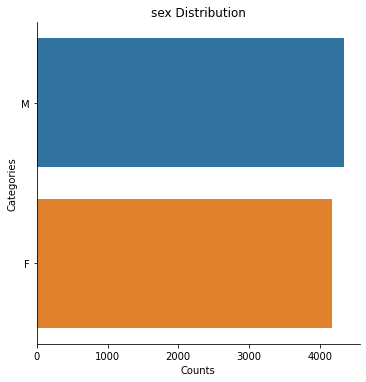

In [12]:
data.plot(scope='sex', subjects='all', decode_values=True, count=True)

## Define a train-test split

What if we wanted to define a train-test split? But also do it according to some criteria, say stratifying by sex?

In [13]:
# First define a CVStrategy that says stratify by sex
sex_strat = bp.CVStrategy(stratify='sex')
sex_strat

CVStrategy(stratify='sex')

In [14]:
# Apply the test_split
data = data.set_test_split(size=.2, cv_strategy=sex_strat, random_state=2)
data

Performing test split on: 8520 subjects.
random_state: 2
Test split size: 0.2

Performed train/test split
Train size: 6816
Test size:  1704


,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.post.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.post.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.frontomargin.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.frontomargin.rh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.occipital.inf.lh,tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.occipital.inf.rh,...,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_inf.lat.vent.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_inf.lat.vent.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_pallidum.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_pallidum.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_putamen.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_putamen.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.rh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_ventraldc.lh,tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_ventraldc.rh
0,0.168032,0.153849,0.045860,0.023883,0.081824,0.015926,0.142664,0.035705,-0.169860,-0.128688,...,-0.036716,0.052883,-0.006478,-0.025535,0.030901,-0.022286,0.091828,0.158497,0.101536,0.234851
2,0.052402,0.101880,0.111399,0.124650,0.113433,0.125727,0.579317,0.611870,0.224255,0.343618,...,-0.070160,0.097003,0.026871,0.191424,0.026224,0.036808,0.091165,0.044027,0.071074,0.042021
3,-0.092771,0.007574,0.182024,0.115439,0.096595,0.096851,0.289666,-0.129820,0.188761,0.178344,...,0.342260,-0.114128,-0.097753,-0.082544,-0.145369,-0.187083,-0.159170,-0.113892,-0.242210,-0.175904
4,-0.144128,-0.074626,-0.001618,0.142387,0.241128,0.227172,-0.141231,0.475396,0.573906,1.363352,...,-0.183606,-0.118741,-0.055955,0.046954,-0.018277,0.092319,0.053306,0.060963,0.116601,-0.102220
5,-0.243239,-0.152293,-0.078217,-0.061314,-0.044547,-0.096233,0.298622,-0.083202,-0.082675,-0.071584,...,0.015237,0.129581,0.222719,0.122448,0.244788,0.159455,0.342455,0.230097,0.133497,0.230591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11870,-0.103273,-0.060990,0.008791,0.186439,0.059300,0.047829,0.130752,0.184572,0.100078,0.049040,...,0.010403,-0.149049,-0.024082,0.016314,-0.045987,-0.090321,0.066490,0.055350,0.022404,0.095318
11871,-0.060443,-0.123368,-0.024308,-0.122978,-0.143336,-0.098973,0.327409,0.055603,-0.203490,-0.129804,...,-0.168353,0.058014,-0.080418,0.080907,-0.095893,-0.069077,0.009947,0.034421,0.007450,-0.075879
11872,0.012809,0.010143,0.012343,-0.006711,-0.072679,-0.084823,-0.203417,-0.210167,-0.270940,-0.143613,...,-0.044618,0.116003,0.264322,0.134182,0.323175,0.366650,0.254944,0.388157,0.411429,0.312342
11873,0.164396,0.202513,0.376726,0.257396,0.371823,0.123384,0.507308,0.788963,0.260868,0.246349,...,0.538963,-0.930948,-0.225716,-0.347940,-0.305339,-0.380956,-0.123154,-0.251212,-0.270063,-0.336481


## Define an ML Pipeline

In [15]:
# Let's define a Pipeline, first by creating a series of based objects

# Standard Scaling
scaler = bp.Scaler('standard', scope='float')

# Ridge Regression model
ridge = bp.Model('ridge', params=1)

# Parameter search strategy,
# using different evolution and a custom nested
# CV strategy.
search = bp.ParamSearch(search_type='DE',
                        n_iter=60,
                        cv=bp.CV(splits=.5,
                                 n_repeats=5))

pipe = bp.Pipeline([scaler, ridge], param_search=search)
pipe

Pipeline(param_search=ParamSearch(cv=CV(cv_strategy=CVStrategy(), n_repeats=5,
                                        splits=0.5),
                                  n_iter=60, search_type='DE'),
         steps=[Scaler(obj='standard'), Model(obj='ridge', params=1)])

## Evaluating an ML Pipeline

In [16]:
# We can store some commonly used parameters in this
# ProblemSpec object. Though note, problem_type and scorer can both be automatically
# detected and set.
spec = bp.ProblemSpec(problem_type='regression',
                      scorer=['r2', 'explained_variance', 'neg_mean_squared_error'],
                      random_state=51,
                      n_jobs=8)

In [17]:
results = bp.evaluate(pipeline=pipe,
                      dataset=data,
                      problem_spec=spec,
                      subjects='train', # This line is important! It says we only want to evaluate on the train set
                      cv=3)
results

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'r2': 0.07958835201902088, 'explained_variance': 0.07967997124605375, 'neg_mean_squared_error': -6010.648630526718}
std_scores = {'r2': 0.011299061390542244, 'explained_variance': 0.01136276831924015, 'neg_mean_squared_error': 69.94297102088669}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_']

Avaliable Methods: ['get_preds_dfs', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=8, problem_type='regression', random_state=51,
            scorer={'explained_variance': make_scorer(explained_variance_score),
                    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
                    'r2': make_scorer(r2_score)},
            subjects='train', target='tfmri_sst_all_beh_total_mean.rt')

In [18]:
# Helper to get mean feature importances, in this case beta weights
results.get_fis(mean=True)

tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.lh         0.076272
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.rh        -0.028153
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.lh     0.595893
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.rh    -0.645362
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.post.lh   -0.886834
                                                                                         ...   
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_putamen.rh                3.186791
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.lh       -0.889136
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.rh       -1.596109
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_ventraldc.lh             -1.066655
tfmri_sst_all_incorrect.stop.vs.correct.

Since a train-test split is being employed, there would at this stage likely be some sort of exploration of different pipelines. Or for example exploration with a limited feature set, i.e., what if we only want to try one of the contrasts? We can just specify a scope.

In [19]:
results = bp.evaluate(pipeline=pipe,
                      dataset=data,
                      problem_spec=spec,
                      scope='tfmri_sst_all_incorrect.stop.vs.correct.go_beta_',
                      subjects='train',
                      cv=3)
results

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'r2': 0.05329125867332377, 'explained_variance': 0.05331184756755399, 'neg_mean_squared_error': -6182.756570504683}
std_scores = {'r2': 0.002120697874907853, 'explained_variance': 0.002123490497874701, 'neg_mean_squared_error': 64.95993611544839}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_']

Avaliable Methods: ['get_preds_dfs', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=8, problem_type='regression', random_state=51,
            scope='tfmri_sst_all_incorrect.stop.vs.correct.go_beta_',
            scorer={'explained_variance': make_scorer(explained_variance_score),
                    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
                    'r2': make_scorer(r2_score)},
            subjects='train', target='tfmri_sst_all

Or along the same lines, we could also specify a sub-set of subects to evaluate by. We can use two custom input objects for this.

In [20]:
sex_m = bp.ValueSubset('sex', 'M', decode_values=True)
sex_f = bp.ValueSubset('sex', 'F', decode_values=True)

sex_m_train = bp.Intersection(['train', sex_m])
sex_f_train = bp.Intersection(['train', sex_f])

# Look at what this refers to explicitly
len(data.get_subjects(sex_m_train)), len(data.get_subjects(sex_f_train))

(3478, 3338)

In [21]:
results = bp.evaluate(pipeline=pipe,
                      dataset=data,
                      problem_spec=spec,
                      scope='tfmri_sst_all_incorrect.stop.vs.correct.go_beta_',
                      subjects=sex_m_train,
                      cv=3)
results

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'r2': 0.032502829042323635, 'explained_variance': 0.034186186821261545, 'neg_mean_squared_error': -6389.447835404739}
std_scores = {'r2': 0.011279438938844285, 'explained_variance': 0.010234922208467674, 'neg_mean_squared_error': 486.9191330435646}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_']

Avaliable Methods: ['get_preds_dfs', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=8, problem_type='regression', random_state=51,
            scope='tfmri_sst_all_incorrect.stop.vs.correct.go_beta_',
            scorer={'explained_variance': make_scorer(explained_variance_score),
                    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
                    'r2': make_scorer(r2_score)},
            subjects=Intersection(['train', Value

## Comparing different pipelines

What if we wanted to explicitly compare results by sex? We have another special objects for that called Compare. Compare will run a seperate evaluate for each Option, where an Option represents a choice.

In [22]:
compare_subjects = bp.Compare([bp.Option(sex_m_train, name='M'),
                               bp.Option(sex_f_train, name='F')])

results = bp.evaluate(pipeline=pipe,
                      dataset=data,
                      problem_spec=spec,
                      scope='tfmri_sst_all_incorrect.stop.vs.correct.go_beta_',
                      subjects=compare_subjects,
                      cv=3)

# The returned CompareDict has a special summary method
results.summary()

Compare:   0%|          | 0/2 [00:00<?, ?it/s]

Folds:   0%|          | 0/3 [00:00<?, ?it/s]

,mean_scores_r2,mean_scores_explained_variance,mean_scores_neg_mean_squared_error,std_scores_r2,std_scores_explained_variance,std_scores_neg_mean_squared_error,mean_timing_fit,mean_timing_score
subjects,,,,,,,,
M,0.034580,0.036287,-6374.996213,0.010381,0.009322,475.103842,6.011585,0.015674
F,0.052949,0.053255,-6106.857657,0.008802,0.008576,482.504150,5.880439,0.018481


## Using the Test Set

While in practice you might want to explore more options with the train set first, let's just move on to showing how we could test a final pipeline on the testing set, while training on the full train set.

In [23]:
results = bp.evaluate(pipeline=pipe,
                      dataset=data,
                      problem_spec=spec,
                      scope='all', # Use all three contrasts
                      subjects='all', # Use all subjects, not just train
                      cv='test' # Special argument to train on full train and test on test
                     )
results

Folds:   0%|          | 0/1 [00:00<?, ?it/s]

BPtEvaluator
------------
mean_scores = {'r2': 0.078986931622118, 'explained_variance': 0.0790867898118649, 'neg_mean_squared_error': -5903.850290271676}
std_scores = {'r2': 0.0, 'explained_variance': 0.0, 'neg_mean_squared_error': 0.0}

Saved Attributes: ['estimators', 'preds', 'timing', 'train_indices', 'val_indices', 'feat_names', 'ps', 'mean_scores', 'std_scores', 'weighted_mean_scores', 'scores', 'fis_', 'coef_']

Avaliable Methods: ['get_preds_dfs', 'get_fis', 'get_coef_', 'permutation_importance']

Evaluated with:
ProblemSpec(n_jobs=8, problem_type='regression', random_state=51,
            scorer={'explained_variance': make_scorer(explained_variance_score),
                    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
                    'r2': make_scorer(r2_score)},
            subjects='all', target='tfmri_sst_all_beh_total_mean.rt')

In [24]:
fis = results.get_fis(mean=True)
fis

tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.lh         0.094251
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.ant.rh        -0.067232
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.lh     0.687618
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.ant.rh    -0.718095
tfmri_sst_all_correct.go.vs.fixation_beta_cort.destrieux_g.and.s.cingul.mid.post.lh   -1.154759
                                                                                         ...   
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_putamen.rh                3.647012
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.lh       -1.002378
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_thalamus.proper.rh       -2.003057
tfmri_sst_all_incorrect.stop.vs.correct.go_beta_subcort.aseg_ventraldc.lh             -1.045507
tfmri_sst_all_incorrect.stop.vs.correct.

## Plotting results

To plot feature importance results we are going to use a different library avaliable at https://github.com/sahahn/Neuro_Plotting, in addition to the library nilearn.

In [25]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_glass_brain, plot_stat_map

# We will use some extra loading functions
from Neuro_Plotting.Ref import SurfRef, VolRef, load_mapping, save_mapping
from Neuro_Plotting.Plot import Plot_Surf, Plot_Surf_Collage, Plot_SurfVol_Collage

In [26]:
# The directory where you install Neuro_Plotting
data_dr = '/home/sage/Neuro_Plotting/data/'

In [27]:
# Need as DataFrame not Series
fis_df = pd.DataFrame(fis).reset_index()
fis_df

,index,0
0,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,0.094251
1,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,-0.067232
2,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,0.687618
3,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,-0.718095
4,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,-1.154759
...,...,...
502,tfmri_sst_all_incorrect.stop.vs.correct.go_bet...,3.647012
503,tfmri_sst_all_incorrect.stop.vs.correct.go_bet...,-1.002378
504,tfmri_sst_all_incorrect.stop.vs.correct.go_bet...,-2.003057
505,tfmri_sst_all_incorrect.stop.vs.correct.go_bet...,-1.045507


In [28]:
surf_ref = SurfRef(data_dr, space='fsaverage5', parc='destr')

# Get beta weights seperate by contrast and hemisphere
betas = []
for c_key in contrasts:
    
    b = surf_ref.get_hemis_plot_vals(fis_df,
                                     lh_key='.lh',
                                     rh_key='.rh',
                                     i_keys=['.destrieux', c_key])
    betas.append(b)

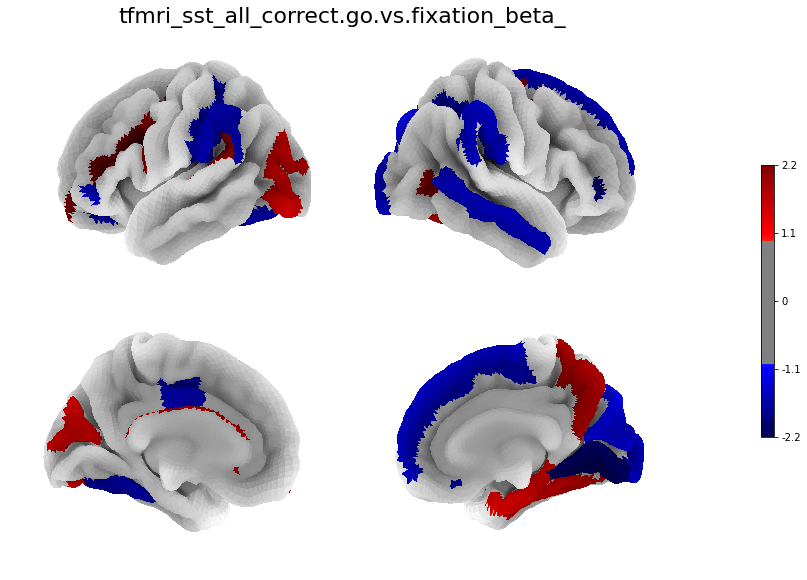

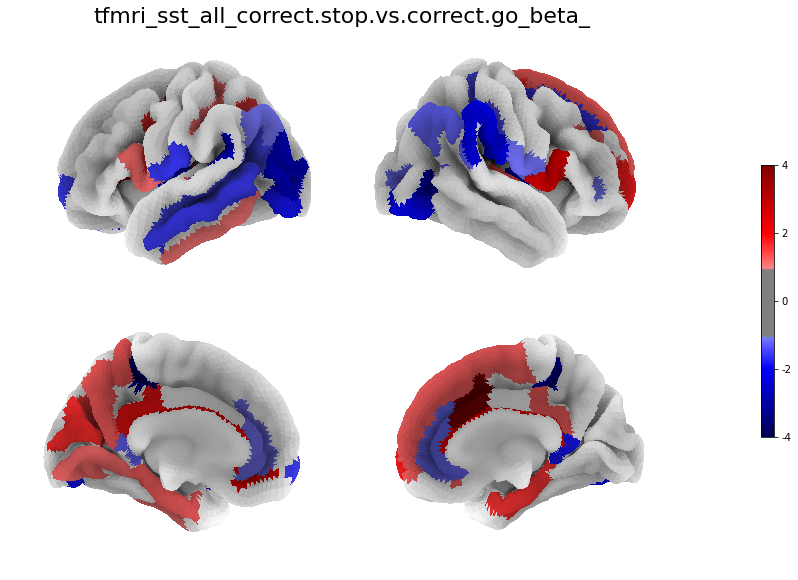

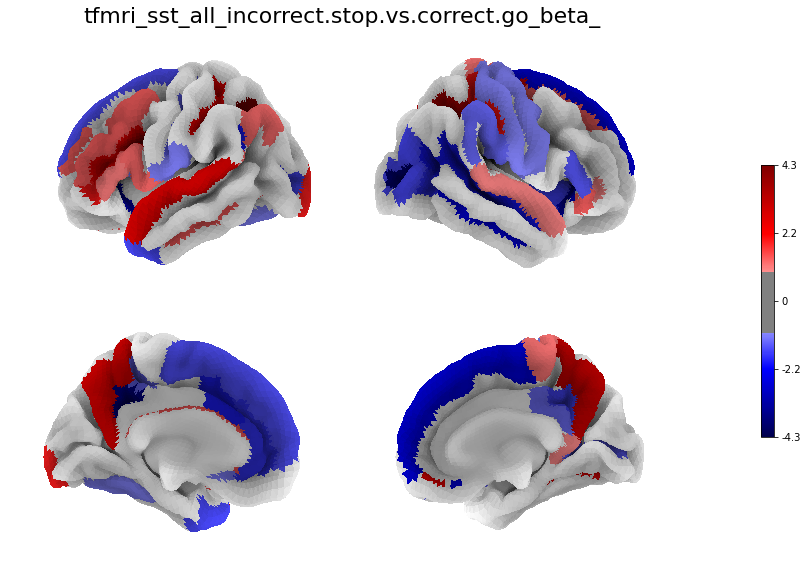

In [29]:
for i in range(len(betas)):
    figure, axes, smf = Plot_Surf_Collage(data = betas[i],
                                          ref = surf_ref,
                                          surf_mesh = 'pial',
                                          bg_map = 'sulc',
                                          view = 'standard',
                                          cmap = 'seismic',
                                          title = contrasts[i],
                                          title_sz = 22,
                                          threshold = 1,
                                          dist= 6.25,
                                          wspace = 0,
                                          hspace = 0,
                                          figsize = (15, 10),
                                          avg_method = 'median',
                                          bg_on_data = True,
                                          alpha = 1,
                                          colorbar = True)
    
    # Optionally save data
    #plt.savefig(contrast_keys[i] + '.png', dpi=100, bbox_inches='tight')

In [30]:
vol_ref = VolRef(data_dr, space='mni', parc='aseg_2mm')

vols = []
for c_key in contrasts:
    vols.append(vol_ref.get_plot_vals(fis_df, i_keys=['_subcort.aseg', c_key], d_keys=[]))

vols

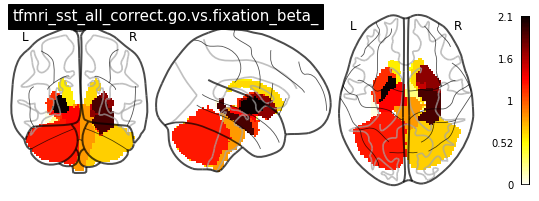

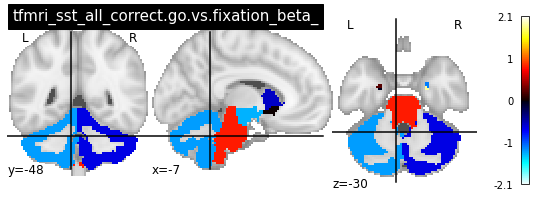

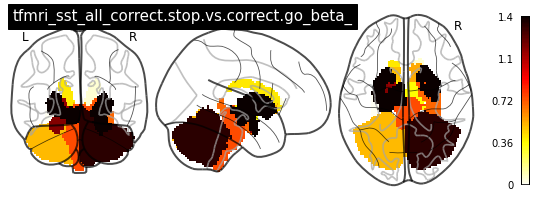

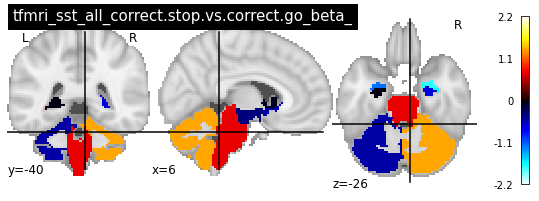

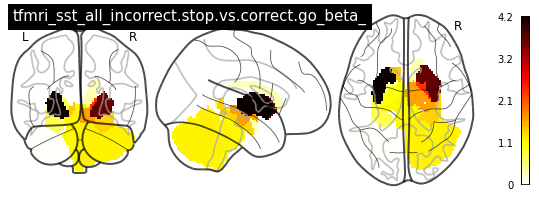

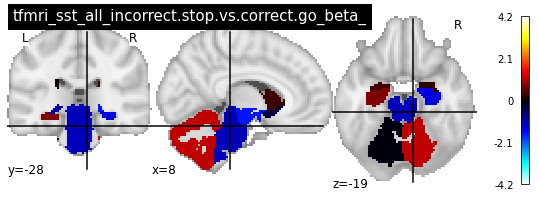

In [31]:
for i in range(len(contrasts)):
    plot_glass_brain(vols[i], colorbar=True, title=contrasts[i])
    plot_stat_map(vols[i], title=contrasts[i])